# Binary classification of images with a convolutional DNN

In [ ]:
!apt-get install unzip
!pip install -U --no-cache-dir \
  tensorflow==1.12.0 \
  tensorflow-gpu==1.12.0 \
  kaggle \
  pillow

In [ ]:
# !echo '{"username":"","key":""}' > /content/.kaggle/kaggle.json \
#   && chmod 600 /content/.kaggle/kaggle.json

!KAGGLE_CONFIG_DIR=/content/.kaggle kaggle competitions download -c dogs-vs-cats -p /content/data

!unzip -n -q /content/data/train.zip -d /content/data
!unzip -n -q /content/data/test1.zip -d /content/data


Populating the interactive namespace from numpy and matplotlib


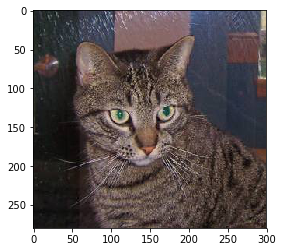

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

original_data_dir = '/content/data/train'

img = mpimg.imread(os.path.join(original_data_dir, 'cat.1.jpg'))
imgplot = plt.imshow(img)
plt.show()